In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.compose import ColumnTransformer

from scipy import stats

import category_encoders as ce
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, plot_roc_curve, brier_score_loss, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

To simplify the deployment process I decide to remove the variables with high cardinality e.g. `Region_Code` and `Policy_Sales_Channel`

In [2]:
df = pd.read_csv('./archive/train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
X = df.drop(['id', 'Region_Code', 'Policy_Sales_Channel', 'Response'], axis=1)
y = df['Response']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2021)

In [5]:
smote = SMOTE(sampling_strategy='minority')
lgbm = LGBMClassifier(n_jobs=-1)
oh_enc = OneHotEncoder(drop='first')
scaler = StandardScaler()
pca = PCA(n_components=2)
smote = SMOTE(random_state=2021)
cal = CalibratedClassifierCV(base_estimator=lgbm, 
                            cv=10, method='isotonic')
skf = StratifiedKFold(n_splits=5)

num_pipe = Pipeline([
    ('scaler', scaler),
    ('pca', pca)
])

transformer = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(drop='first'), ['Gender', 'Vehicle_Age', 'Vehicle_Damage']),
    ('numerical_prep', num_pipe, ['Age', 'Vintage', 'Annual_Premium'])
])

estimator = Pipeline([
    ('transformer', transformer),
    ('sampler', smote),
    ('clf', cal)
])

estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76     83600
           1       0.25      0.94      0.40     11678

    accuracy                           0.66     95278
   macro avg       0.62      0.78      0.58     95278
weighted avg       0.90      0.66      0.71     95278



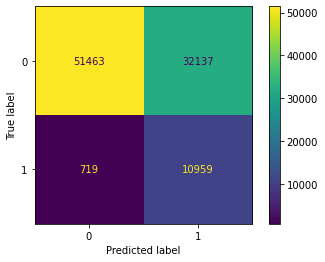

In [6]:
plot_confusion_matrix(estimator, X_test, y_test);

In [7]:
def plot_calibration_curve(y_true, probs, bins, model):

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, probs, n_bins=bins, strategy='uniform')
    
    max_val = max(mean_predicted_value)
    
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, label=type(model).__name__)
    plt.plot(np.linspace(0, max_val, bins), np.linspace(0, max_val, bins),
         linestyle='--', color='red', label='Perfect calibration')
    
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of positive examples')
    plt.title('Calibration Curve')
    plt.legend(loc='upper left')


    plt.subplot(2, 1, 2)
    plt.hist(probs, range=(0, 1), bins=bins, density=False, stacked=True, alpha=0.3)
    plt.xlabel('Probability Predictions')
    plt.ylabel('Fraction of examples')
    plt.title('Density')
    plt.show()

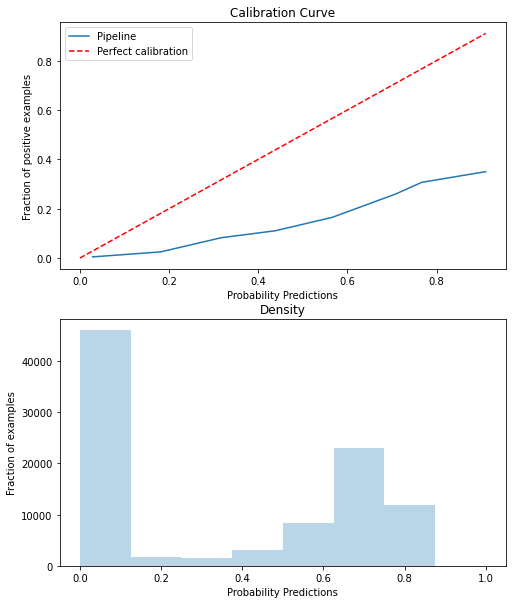

In [8]:
proba = estimator.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, proba, bins=8, model=estimator)

## Save Model

In [9]:
filtered_entries = np.array([True] * len(X))

col = 'Annual_Premium'
Q1 = X[col].quantile(0.25)
Q3 = X[col].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

filtered_entries = ((X[col] >= low_limit) & (X[col] <= high_limit)) & filtered_entries

X_filtered, y_filtered = X[filtered_entries], y[filtered_entries]

In [10]:
import pickle

estimator.fit(X_filtered, y_filtered)

pickle.dump(estimator, open('estimator_deploy.sav', 'wb'))

In [12]:
X_filtered.describe()

,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage
count,370789.000000,370789.000000,370789.000000,370789.000000,370789.000000
mean,38.670344,0.997942,0.459666,29264.643973,154.345442
std,15.440166,0.045316,0.498371,14743.056656,83.670478
min,20.000000,0.000000,0.000000,2630.000000,10.000000
25%,25.000000,1.000000,0.000000,24102.000000,82.000000
50%,36.000000,1.000000,0.000000,31319.000000,154.000000
75%,49.000000,1.000000,1.000000,38596.000000,227.000000
max,85.000000,1.000000,1.000000,61892.000000,299.000000


In [16]:
df['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64